<a href="https://colab.research.google.com/github/anjalii-s/Thesis-2026-/blob/main/final_LC_10_myerson_kuncheva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================
# 1. Install & Imports
# ============================================================
!pip install -q pyspark imbalanced-learn shap lightgbm xgboost seaborn scikit-learn pandas numpy matplotlib networkx statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import networkx as nx
from scipy import stats
from scipy.spatial.distance import cosine
from sklearn.cluster import AgglomerativeClustering
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

# ============================================================
# 2. Load & Preprocess Lending Club Dataset
# ============================================================
print("\n" + "="*80)
print("LOADING AND PREPROCESSING LENDING CLUB DATASET")
print("="*80)
# Load dataset
df = pd.read_csv('LC_50K 10 pc df.csv')
# Clean and prepare
df = df.rename(columns={'Default': 'target'})
columns_to_drop = ['id', 'issue_d', 'zip_code', 'title', 'desc']
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=existing_columns_to_drop)
# Handle missing values
for column in df.columns:
    if df[column].isnull().sum() > 0:
        if df[column].dtype in ['int64', 'float64']:
            df[column].fillna(df[column].median(), inplace=True)
        else:
            df[column].fillna(df[column].mode()[0], inplace=True)
X = df.drop('target', axis=1)
y = df['target'].astype(int)
print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"Default rate: {(y.mean() * 100):.2f}%")
print(f"Imbalance ratio: {sum(y==0)/sum(y==1):.2f}:1")
# Identify categorical and numeric columns
cat_cols = ['experience_c', 'emp_length', 'purpose', 'home_ownership_n', 'addr_state']
cat_cols = [col for col in cat_cols if col in X.columns]
num_cols = [c for c in X.columns if c not in cat_cols]
print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numeric columns ({len(num_cols)}): {num_cols}")
# Create preprocessing pipeline
cat_categories = [sorted(X[col].dropna().unique().tolist()) for col in cat_cols]
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False, categories=cat_categories), cat_cols),
    ('num', StandardScaler(), num_cols)
])
# Fit preprocessor
X_processed = preprocessor.fit_transform(X)
d = X_processed.shape[1]
print(f"\nNumber of processed features: {d}")

# ============================================================
# 3. Models & Sampling Strategies
# ============================================================
models = {
    'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGB': xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42, eval_metric='logloss', n_jobs=-1),
    'LGB': lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42, verbose=-1, n_jobs=-1)
}
resamplers = {
    'None': None,
    'Under': RandomUnderSampler(random_state=42),
    'CostSensitive': 'cost',
    'SMOTE': SMOTE(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42)
}
# Compute class weights
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}
print(f"\nClass weights: {class_weight_dict}")

# ============================================================
# 4. Explanation Methods
# ============================================================
def get_shap_reliable(pipe, X_test):
    """Get SHAP values reliably"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        if isinstance(sv, list):
            return sv[1]
        elif sv.ndim == 3:
            return sv[:, :, 1]
        else:
            return sv
    except Exception as e:
        print(f"SHAP failed: {e}")
        # Fallback to permutation importance
        from sklearn.inspection import permutation_importance
        res = permutation_importance(clf, X_proc, pipe.predict(X_proc), n_repeats=3, random_state=42)
        return np.tile(res.importances_mean, (X_proc.shape[0], 1))

def compute_banzhaf(pipe, X_test, n_samples=5, max_instances=5):
    """Compute Banzhaf values"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))
    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                # Create random coalition
                coal = np.random.binomial(1, 0.5, n_feat)
                # With feature f
                x_with = x.copy()
                x_with[0, f] = x[0, f] * coal[f]
                p1 = clf.predict_proba(x_with)[0, 1]
                # Without feature f
                x_without = x.copy()
                x_without[0, f] = 0
                p0 = clf.predict_proba(x_without)[0, 1]
                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

# ============================================================
# 5. Myerson Value Functions
# ============================================================
def build_feature_graph(preprocessor, X, threshold=0.25):
    """Build feature graph based on correlation"""
    X_proc = preprocessor.transform(X)
    corr = np.corrcoef(X_proc.T)
    G = nx.Graph()
    d = corr.shape[0]
    G.add_nodes_from(range(d))
    for i in range(d):
        for j in range(i+1, d):
            if abs(corr[i, j]) >= threshold:
                G.add_edge(i, j, weight=corr[i, j])
    return G, corr

def myerson_value(pipe, X_test, G, alpha=0.5, max_instances=50):
    """Compute Myerson values"""
    shap_vals = get_shap_reliable(pipe, X_test)
    shap_mean = shap_vals.mean(axis=0)
    d = len(shap_mean)
    phi = np.zeros(d)
    for i in range(d):
        neighbors = list(G.neighbors(i))
        if len(neighbors) == 0:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean
    n_out = min(max_instances, len(X_test))
    return np.tile(phi, (n_out, 1))

# ============================================================
# 6. Owen Value Functions with Multiple Grouping Strategies
# ============================================================
def get_feature_names_out(preprocessor):
    """Get feature names after preprocessing"""
    return preprocessor.get_feature_names_out()

def build_domain_groups(fnames):
    """Build domain-driven groups"""
    groups = {
        "EmploymentIncome": [],
        "LoanCharacteristics": [],
        "Purpose": [],
        "AssetsCollateral": [],
        "Location": []
    }
    for i, name in enumerate(fnames):
        lname = name.lower()
        if any(k in lname for k in ["experience_c", "emp_length", "revenue", "dti_n", "fico_n"]):
            groups["EmploymentIncome"].append(i)
        if "loan_amnt" in lname:
            groups["LoanCharacteristics"].append(i)
        if "purpose" in lname:
            groups["Purpose"].append(i)
        if "home_ownership_n" in lname:
            groups["AssetsCollateral"].append(i)
        if "addr_state" in lname:
            groups["Location"].append(i)
    return {g: v for g, v in groups.items() if len(v) > 0}

def build_data_groups(X_proc, n_groups=6):
    """Build data-driven groups using correlation clustering"""
    try:
        # Clean and compute correlation
        X_proc = np.nan_to_num(X_proc, nan=0.0)
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(X_proc.T)
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)
        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)
        # Adjust number of groups if needed
        if X_proc.shape[1] < n_groups:
            n_groups = max(2, X_proc.shape[1] // 2)
        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)
        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Cluster_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"Data-driven grouping failed: {e}")
        n_features = X_proc.shape[1]
        return {"Default_Group": list(range(n_features))}, np.eye(n_features)

def build_model_groups(shap_vals, n_groups=6):
    """Build model-driven groups from SHAP values"""
    try:
        shap_vals = np.nan_to_num(shap_vals, nan=0.0)
        if shap_vals.ndim == 1:
            shap_vals = shap_vals.reshape(1, -1)
        elif shap_vals.ndim == 3:
            shap_vals = shap_vals.mean(axis=2) if shap_vals.shape[2] > 1 else shap_vals.squeeze()
        if shap_vals.shape[0] < shap_vals.shape[1]:
            shap_vals = shap_vals.T
        if shap_vals.shape[0] < 2:
            n_features = shap_vals.shape[1] if shap_vals.shape[0] == 1 else shap_vals.shape[0]
            return {"Default_Group": list(range(n_features))}, np.eye(n_features)
        # Compute correlation of SHAP values
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(shap_vals)
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)
        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)
        n_features = corr.shape[0]
        if n_features < n_groups:
            n_groups = max(2, n_features // 2)
        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)
        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"SHAPGroup_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"Model-driven grouping failed: {e}")
        n_features = shap_vals.shape[1] if shap_vals.ndim > 1 else shap_vals.shape[0]
        return {"Default_Group": list(range(n_features))}, np.eye(n_features)

def owen_from_shap(phi, groups):
    """Compute Owen values from SHAP values using groups"""
    d = len(phi)
    out = np.zeros(d)
    for _, feats in groups.items():
        if len(feats) == 0:
            continue
        valid_feats = [f for f in feats if f < d]
        if not valid_feats:
            continue
        total = np.sum(np.abs(phi[valid_feats]))
        per = total / len(valid_feats)
        for f in valid_feats:
            sign = np.sign(phi[f]) if phi[f] != 0 else 1
            out[f] = sign * per
    return out

# ============================================================
# 7. Interpretability Metrics
# ============================================================
def stability_cv(expl_list):
    """Compute stability (coefficient of variation)"""
    if len(expl_list) < 2:
        return 1.0
    try:
        arr = np.stack([np.abs(e) for e in expl_list])
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))
    except:
        return 1.0

def kuncheva_index(expl_list, k=5):
    """Compute Kuncheva index for top-K feature consistency"""
    if len(expl_list) < 2:
        return 0.0
    sets = []
    for exp in expl_list:
        try:
            imp = np.abs(exp).mean(axis=0).ravel()
            topk = min(k, len(imp))
            topk_indices = set(np.argsort(imp)[-topk:].tolist())
            sets.append(topk_indices)
        except:
            sets.append(set())
    if len(sets) < 2:
        return 0.0
    ki_values = []
    for i in range(len(sets)):
        for j in range(i+1, len(sets)):
            intersection = len(sets[i] & sets[j])
            if k == d:
                ki = 0.0
            else:
                ki = (intersection - (k**2)/d) / (k - (k**2)/d)
            ki = max(min(ki, 1.0), -1.0)
            ki_values.append(ki)
    return float(np.mean(ki_values)) if ki_values else 0.0

def cosine_directional_consistency(expl_list):
    """Compute cosine similarity between explanation vectors"""
    if len(expl_list) < 2:
        return 1.0
    try:
        # Get mean explanation vectors for each fold
        mean_vecs = [np.mean(np.abs(e), axis=0).ravel() for e in expl_list]
        cos_sims = []
        for i in range(len(mean_vecs)):
            for j in range(i+1, len(mean_vecs)):
                if np.linalg.norm(mean_vecs[i]) == 0 or np.linalg.norm(mean_vecs[j]) == 0:
                    cos_sim = 0.0
                else:
                    cos_sim = 1 - cosine(mean_vecs[i], mean_vecs[j])
                cos_sims.append(cos_sim)
        return float(np.mean(cos_sims)) if cos_sims else 0.0
    except:
        return 0.0

def interpretability_score(cv, kuncheva, cosine_sim, beta=0.3):
    return beta * (1 - cv) + beta * kuncheva + beta * cosine_sim

def normalize(s):
    """Normalize a series to [0,1]"""
    return (s - s.min()) / (s.max() - s.min() + 1e-8)

def tradeoff_metric(auc_series, I_series, alpha=0.5):
    """Compute trade-off metric between AUC and interpretability"""
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

# ============================================================
# 8. Main Experiment Loop
# ============================================================
print("\n" + "="*80)
print("STARTING COMPREHENSIVE EXPERIMENT")
print("="*80)
# Build feature graph for Myerson
print("\nBuilding feature graph for Myerson value...")
G_myerson, _ = build_feature_graph(preprocessor, X, threshold=0.25)
print(f"Graph built with {G_myerson.number_of_nodes()} nodes and {G_myerson.number_of_edges()} edges")
# Setup cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
all_records = []
# Main experiment loop
for mname, model in models.items():
    for sname, sampler in resamplers.items():
        print(f"\n{'='*60}")
        print(f"Processing: {mname} + {sname}")
        print(f"{'='*60}")
        # Store results for each method
        aucs = []
        shap_runs, banzhaf_runs, myerson_runs = [], [], []
        owen_domain_runs, owen_data_runs, owen_model_runs = [], [], []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
            # Create pipeline
            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)
            # Apply cost-sensitive learning if needed
            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0]
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
            # Train model
            pipe.fit(X_tr, y_tr)
            # Compute AUC
            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)
            print(f" Fold {fold}: AUC = {auc:.4f}")
            # Sample for explanations
            X_sample = X_te.sample(n=min(50, len(X_te)), random_state=42)
            # 1. SHAP
            try:
                shap_vals = get_shap_reliable(pipe, X_sample)
                shap_runs.append(shap_vals)
            except Exception as e:
                print(f" SHAP failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                shap_runs.append(np.zeros((min(50, len(X_sample)), n_features)))
            # 2. Banzhaf
            try:
                banzhaf_vals = compute_banzhaf(pipe, X_sample)
                banzhaf_runs.append(banzhaf_vals)
            except Exception as e:
                print(f" Banzhaf failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                banzhaf_runs.append(np.zeros((min(5, len(X_sample)), n_features)))
            # 3. Myerson
            try:
                myerson_vals = myerson_value(pipe, X_sample, G_myerson)
                myerson_runs.append(myerson_vals)
            except Exception as e:
                print(f" Myerson failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                myerson_runs.append(np.zeros((min(50, len(X_sample)), n_features)))
            # 4. Owen with different grouping strategies
            try:
                # Get SHAP values for Owen
                shap_vals_owen = get_shap_reliable(pipe, X_sample)
                phi = np.mean(shap_vals_owen, axis=0)
                # Get feature names
                fnames = get_feature_names_out(preprocessor)
                # Domain-driven groups
                dom_groups = build_domain_groups(fnames)
                owen_domain_vals = np.tile(owen_from_shap(phi, dom_groups), (min(50, len(X_sample)), 1))
                owen_domain_runs.append(owen_domain_vals)
                # Data-driven groups
                X_tr_proc = pipe.named_steps['prep'].transform(X_tr)
                data_groups, _ = build_data_groups(X_tr_proc)
                owen_data_vals = np.tile(owen_from_shap(phi, data_groups), (min(50, len(X_sample)), 1))
                owen_data_runs.append(owen_data_vals)
                # Model-driven groups
                X_tr_sample = X_tr.sample(n=min(100, len(X_tr)), random_state=42)
                shap_tr = get_shap_reliable(pipe, X_tr_sample)
                model_groups, _ = build_model_groups(shap_tr)
                owen_model_vals = np.tile(owen_from_shap(phi, model_groups), (min(50, len(X_sample)), 1))
                owen_model_runs.append(owen_model_vals)
            except Exception as e:
                print(f" Owen failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                zeros = np.zeros((min(50, len(X_sample)), n_features))
                owen_domain_runs.append(zeros)
                owen_data_runs.append(zeros)
                owen_model_runs.append(zeros)
        # Compute average AUC
        auc_mean = np.mean(aucs)
        # Process results for each method
        method_runs = [
            ('SHAP', shap_runs),
            ('Banzhaf', banzhaf_runs),
            ('Myerson', myerson_runs),
            ('Owen_Domain', owen_domain_runs),
            ('Owen_Data', owen_data_runs),
            ('Owen_Model', owen_model_runs)
        ]
        for method_name, runs in method_runs:
            if runs:
                # Only process if we have results
                cv_val = stability_cv(runs)
                kun_val = kuncheva_index(runs, k=5)
                cos_val = cosine_directional_consistency(runs)
                I_val = interpretability_score(cv_val, kun_val, cos_val)
                # Extract grouping type for Owen methods
                if method_name.startswith('Owen_'):
                    grouping = method_name.split('_')[1]
                    method_base = 'Owen'
                else:
                    grouping = 'None'
                    method_base = method_name
                all_records.append({
                    'Model': mname,
                    'Sampler': sname,
                    'Method': method_base,
                    'Grouping': grouping,
                    'AUC': auc_mean,
                    'CV': cv_val,
                    'Stability': 1 - cv_val,
                    'Kuncheva': kun_val,
                    'Cosine': cos_val,
                    'I': I_val
                })

# ============================================================
# 9. Process and Save Results
# ============================================================
print("\n" + "="*80)
print("PROCESSING RESULTS")
print("="*80)
if all_records:
    metrics = pd.DataFrame(all_records)
    metrics['T(α=0.5)'] = tradeoff_metric(metrics['AUC'], metrics['I'])
    print("\nComplete Results:")
    print(metrics.round(4).to_string(index=False))
    # Save results
    metrics.to_csv('complete_results.csv', index=False)
    print("\n✓ Results saved to: complete_results.csv")
    # Summary by method
    print("\n" + "="*80)
    print("SUMMARY BY EXPLANATION METHOD")
    print("="*80)
    summary_method = metrics.groupby('Method').agg({
        'AUC': 'mean',
        'Stability': 'mean',
        'Kuncheva': 'mean',
        'Cosine': 'mean',
        'I': 'mean',
        'T(α=0.5)': 'mean'
    }).round(4)
    print(summary_method)
    # Summary for Owen grouping strategies
    owen_data = metrics[metrics['Method'] == 'Owen']
    if not owen_data.empty:
        print("\n" + "="*80)
        print("OWEN GROUPING STRATEGIES COMPARISON")
        print("="*80)
        owen_summary = owen_data.groupby('Grouping').agg({
            'AUC': 'mean',
            'Stability': 'mean',
            'Kuncheva': 'mean',
            'Cosine': 'mean',
            'I': 'mean',
            'T(α=0.5)': 'mean'
        }).round(4)
        print(owen_summary)
    # Best configurations
    print("\n" + "="*80)
    print("TOP 5 OVERALL CONFIGURATIONS")
    print("="*80)
    top5 = metrics.nlargest(5, 'T(α=0.5)')[['Model', 'Sampler', 'Method', 'Grouping', 'AUC', 'I', 'T(α=0.5)']]
    print(top5.round(4).to_string(index=False))
else:
    print("No results generated!")
    metrics = pd.DataFrame()

# ============================================================
# 10. Statistical Validation
# ============================================================
if not metrics.empty:
    print("\n" + "="*80)
    print("STATISTICAL VALIDATION")
    print("="*80)
    # Prepare data for statistical tests
    methods = ['SHAP', 'Banzhaf', 'Myerson', 'Owen']
    # 10.1 Friedman Test for each metric
    print("\nFriedman Test (Overall Method Differences):")
    for metric in ['AUC', 'I', 'T(α=0.5)', 'Kuncheva', 'Cosine']:
        print(f"\n=== {metric} ===")
        # Create pivot table for Friedman test
        pivoted = metrics.pivot_table(values=metric, index=['Model', 'Sampler', 'Grouping'], columns='Method', aggfunc='first')
        # Keep only methods with data for all configurations
        methods_with_data = [m for m in methods if m in pivoted.columns]
        if len(methods_with_data) >= 2:
            data_for_test = [pivoted[m].dropna().values for m in methods_with_data]
            if len(data_for_test[0]) >= 2:
                stat, p = stats.friedmanchisquare(*data_for_test)
                # Compute Kendall's W
                n = len(data_for_test[0])
                k = len(methods_with_data)
                kendall_w = stat / (n * (k - 1))
                print(f"Methods: {methods_with_data}")
                print(f"Friedman χ² = {stat:.3f}, p = {p:.4f}")
                print(f"Kendall's W = {kendall_w:.4f}")
                print(f"Significant: {'Yes' if p < 0.05 else 'No'}")
            else:
                print(f"Insufficient data for {metric}")
        else:
            print(f"Insufficient methods for {metric}")
    # 10.2 Pairwise Wilcoxon Tests
    print("\n" + "="*80)
    print("PAIRWISE WILCOXON TESTS")
    print("="*80)
    pairs = [('SHAP', 'Banzhaf'), ('SHAP', 'Myerson'), ('SHAP', 'Owen'), ('Banzhaf', 'Myerson'), ('Banzhaf', 'Owen'), ('Myerson', 'Owen')]
    for metric in ['T(α=0.5)', 'I', 'Kuncheva']:
        print(f"\n=== {metric} ===")
        for m1, m2 in pairs:
            data1 = metrics[metrics['Method'] == m1][metric].values
            data2 = metrics[metrics['Method'] == m2][metric].values
            # Ensure equal lengths
            min_len = min(len(data1), len(data2))
            if min_len >= 2:
                data1 = data1[:min_len]
                data2 = data2[:min_len]
                stat, p = stats.wilcoxon(data1, data2)
                print(f"{m1} vs {m2}: W = {stat:.1f}, p = {p:.4f} ({'*' if p < 0.05 else ''})")
            else:
                print(f"{m1} vs {m2}: Insufficient data")
    # 10.3 Effect Sizes (Cliff's Delta)
    print("\n" + "="*80)
    print("EFFECT SIZES (Cliff's Delta)")
    print("="*80)
    def cliffs_delta(x, y):
        """Compute Cliff's delta effect size"""
        comparisons = [1 if xi > yj else -1 if xi < yj else 0 for xi in x for yj in y]
        return sum(comparisons) / len(comparisons)
    def interpret_delta(delta):
        """Interpret Cliff's delta magnitude"""
        abs_delta = abs(delta)
        if abs_delta < 0.147: return "negligible"
        elif abs_delta < 0.33: return "small"
        elif abs_delta < 0.474: return "medium"
        else: return "large"
    for metric in ['T(α=0.5)', 'I']:
        print(f"\n=== {metric} ===")
        for m1, m2 in pairs:
            data1 = metrics[metrics['Method'] == m1][metric].values
            data2 = metrics[metrics['Method'] == m2][metric].values
            min_len = min(len(data1), len(data2))
            if min_len >= 2:
                data1 = data1[:min_len]
                data2 = data2[:min_len]
                delta = cliffs_delta(data1, data2)
                magnitude = interpret_delta(delta)
                print(f"{m1} vs {m2}: δ = {delta:.4f} ({magnitude})")
    # 10.4 Correlation Analysis
    print("\n" + "="*80)
    print("CORRELATION ANALYSIS")
    print("="*80)
    rho_auc_i, p_auc_i = stats.spearmanr(metrics['AUC'], metrics['I'])
    print(f"AUC vs I: ρ = {rho_auc_i:.4f}, p = {p_auc_i:.4f}")
    rho_stab_kun, p_stab_kun = stats.spearmanr(metrics['Stability'], metrics['Kuncheva'])
    print(f"Stability vs Kuncheva: ρ = {rho_stab_kun:.4f}, p = {p_stab_kun:.4f}")
    rho_stab_cos, p_stab_cos = stats.spearmanr(metrics['Stability'], metrics['Cosine'])
    print(f"Stability vs Cosine: ρ = {rho_stab_cos:.4f}, p = {p_stab_cos:.4f}")
    # 10.5 Bootstrap Confidence Intervals
    print("\n" + "="*80)
    print("BOOTSTRAP 95% CONFIDENCE INTERVALS")
    print("="*80)
    def bootstrap_ci(data, n_bootstrap=1000):
        """Compute bootstrap confidence interval"""
        if len(data) < 2:
            return np.nan, np.nan
        bootstrap_means = []
        for _ in range(n_bootstrap):
            sample = np.random.choice(data, size=len(data), replace=True)
            bootstrap_means.append(np.mean(sample))
        lower = np.percentile(bootstrap_means, 2.5)
        upper = np.percentile(bootstrap_means, 97.5)
        return lower, upper
    for metric in ['T(α=0.5)', 'I', 'AUC']:
        print(f"\n=== {metric} ===")
        for method in methods:
            if method in metrics['Method'].values:
                data = metrics[metrics['Method'] == method][metric].values
                if len(data) >= 2:
                    lower, upper = bootstrap_ci(data)
                    mean_val = np.mean(data)
                    print(f"{method}: {mean_val:.4f} [{lower:.4f}, {upper:.4f}]")

# ============================================================
# 11. Visualization
# ============================================================
if not metrics.empty:
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)
    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')
    # 1. Trade-off by Method
    plt.figure(figsize=(12, 6))
    method_avg = metrics.groupby('Method')['T(α=0.5)'].mean().sort_values(ascending=False)
    colors = ['#4C78A8', '#F58518', '#E45756', '#72B7B2']
    bars = plt.bar(method_avg.index, method_avg.values, color=colors, edgecolor='black')
    plt.bar_label(bars, fmt='%.3f', padding=3)
    plt.ylabel('Trade-off T(α=0.5)')
    plt.title('Average Trade-off by Explanation Method')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('tradeoff_by_method.png', dpi=300, bbox_inches='tight')
    plt.show()
    # 2. Interpretability Components
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # Stability
    stability_avg = metrics.groupby('Method')['Stability'].mean()
    axes[0].bar(stability_avg.index, stability_avg.values, color=colors, edgecolor='black')
    axes[0].set_title('Stability (1 - CV)')
    axes[0].set_ylabel('Score')
    axes[0].set_ylim(0, 1)
    axes[0].grid(axis='y', alpha=0.3)
    # Kuncheva
    kuncheva_avg = metrics.groupby('Method')['Kuncheva'].mean()
    axes[1].bar(kuncheva_avg.index, kuncheva_avg.values, color=colors, edgecolor='black')
    axes[1].set_title('Kuncheva Index')
    axes[1].set_ylabel('Score')
    axes[1].set_ylim(-0.2, 1.2)
    axes[1].grid(axis='y', alpha=0.3)
    # Cosine
    cosine_avg = metrics.groupby('Method')['Cosine'].mean()
    axes[2].bar(cosine_avg.index, cosine_avg.values, color=colors, edgecolor='black')
    axes[2].set_title('Cosine Similarity')
    axes[2].set_ylabel('Score')
    axes[2].set_ylim(0, 1)
    axes[2].grid(axis='y', alpha=0.3)
    plt.suptitle('Interpretability Components by Method', fontsize=14)
    plt.tight_layout()
    plt.savefig('interpretability_components.png', dpi=300, bbox_inches='tight')
    plt.show()
    # 3. Owen Grouping Comparison
    if 'Owen' in metrics['Method'].values:
        owen_data = metrics[metrics['Method'] == 'Owen']
        if not owen_data.empty:
            plt.figure(figsize=(10, 6))
            grouping_avg = owen_data.groupby('Grouping')['T(α=0.5)'].mean()
            grouping_colors = ['#4C78A8', '#F58518', '#E45756']
            bars = plt.bar(grouping_avg.index, grouping_avg.values, color=grouping_colors, edgecolor='black')
            plt.bar_label(bars, fmt='%.3f', padding=3)
            plt.ylabel('Trade-off T(α=0.5)')
            plt.title('Owen Value: Performance by Grouping Strategy')
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.savefig('owen_grouping_comparison.png', dpi=300, bbox_inches='tight')
            plt.show()
    # 4. Scatter: AUC vs Interpretability
    plt.figure(figsize=(10, 6))
    colors_dict = {'SHAP': '#4C78A8', 'Banzhaf': '#F58518', 'Myerson': '#E45756', 'Owen': '#72B7B2'}
    for method in methods:
        if method in metrics['Method'].values:
            method_data = metrics[metrics['Method'] == method]
            plt.scatter(method_data['AUC'], method_data['I'], s=80, alpha=0.7, label=method, color=colors_dict.get(method, 'gray'), edgecolors='black', linewidth=0.5)
    plt.xlabel('AUC')
    plt.ylabel('Interpretability (I)')
    plt.title('AUC vs Interpretability by Method')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('auc_vs_interpretability.png', dpi=300, bbox_inches='tight')
    plt.show()
    # 5. Model Comparison
    plt.figure(figsize=(12, 6))
    models_compare = ['RF', 'XGB', 'LGB']
    model_colors = ['#4C78A8', '#F58518', '#E45756']
    model_data = []
    for model in models_compare:
        if model in metrics['Model'].values:
            model_metrics = metrics[metrics['Model'] == model]
            model_data.append({
                'Model': model,
                'AUC': model_metrics['AUC'].mean(),
                'I': model_metrics['I'].mean(),
                'T(α=0.5)': model_metrics['T(α=0.5)'].mean()
            })
    if model_data:
        model_df = pd.DataFrame(model_data)
        x = np.arange(len(model_df))
        width = 0.25
        plt.bar(x - width, model_df['AUC'], width, label='AUC', color=model_colors[0])
        plt.bar(x, model_df['I'], width, label='Interpretability', color=model_colors[1])
        plt.bar(x + width, model_df['T(α=0.5)'], width, label='Trade-off', color=model_colors[2])
        plt.xlabel('Model')
        plt.ylabel('Score')
        plt.title('Performance by Model Type')
        plt.xticks(x, model_df['Model'])
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    print("\nVisualizations saved:")
    print("1. tradeoff_by_method.png")
    print("2. interpretability_components.png")
    print("3. owen_grouping_comparison.png")
    print("4. auc_vs_interpretability.png")
    print("5. model_comparison.png")

# ============================================================
# 12. Final Summary
# ============================================================
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
if not metrics.empty:
    # Best overall configuration
    best_overall = metrics.loc[metrics['T(α=0.5)'].idxmax()]
    print(f"\n🏆 BEST OVERALL CONFIGURATION:")
    print(f" Model: {best_overall['Model']}")
    print(f" Sampler: {best_overall['Sampler']}")
    print(f" Method: {best_overall['Method']}")
    print(f" Grouping: {best_overall['Grouping']}")
    print(f" AUC: {best_overall['AUC']:.4f}")
    print(f" Interpretability: {best_overall['I']:.4f}")
    print(f" Trade-off: {best_overall['T(α=0.5)']:.4f}")
    # Best by method
    print(f"\n🔍 BEST BY METHOD:")
    for method in methods:
        if method in metrics['Method'].values:
            method_data = metrics[metrics['Method'] == method]
            best_method = method_data.loc[method_data['T(α=0.5)'].idxmax()]
            print(f" {method}: {best_method['Model']}+{best_method['Sampler']} "
                  f"(T={best_method['T(α=0.5)']:.4f})")
    # Method rankings
    print(f"\n📊 METHOD RANKINGS:")
    method_ranks = metrics.groupby('Method')['T(α=0.5)'].mean().sort_values(ascending=False)
    for rank, (method, score) in enumerate(method_ranks.items(), 1):
        print(f" {rank}. {method}: {score:.4f}")
    # Dataset statistics
    print(f"\n📈 DATASET STATISTICS:")
    print(f" Total samples: {len(df)}")
    print(f" Default rate: {(y.mean() * 100):.2f}%")
    print(f" Features: {X.shape[1]} ({len(cat_cols)} categorical, {len(num_cols)} numerical)")
    print(f" Processed features: {d}")
    # Performance summary
    print(f"\n🎯 PERFORMANCE SUMMARY:")
    print(f" Best AUC: {metrics['AUC'].max():.4f}")
    print(f" Best Interpretability: {metrics['I'].max():.4f}")
    print(f" Best Trade-off: {metrics['T(α=0.5)'].max():.4f}")
print("\n" + "="*80)
print("EXPERIMENT COMPLETE!")
print("="*80)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 MB 845.5 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 135.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.0/203.0 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 1.2 MB/s eta 0:00:00

LOADING AND PREPROCESSING LENDING CLUB DATASET
Dataset shape: (50000, 10)
Target distribution: {0: 45000, 1: 5000}
Default rate: 10.00%
Imbalanc

ValueError: Array shapes are incompatible for broadcasting.


STATISTICAL VALIDATION & COMPARATIVE VISUALIZATION
Lending Club 10% Dataset Analysis

1. Kruskal-Wallis Tests (non-parametric group comparison)

Kruskal-Wallis AUC        statistic =    0.000    p = 1.00000    → not significant
Kruskal-Wallis I          statistic =   14.685    p = 0.00211    → SIGNIFICANT
Kruskal-Wallis T(α=0.5)   statistic =    7.066    p = 0.06981    → not significant
Kruskal-Wallis Stability  statistic =   74.905    p = 0.00000    → SIGNIFICANT
Kruskal-Wallis Kuncheva   statistic =   20.091    p = 0.00016    → SIGNIFICANT
Kruskal-Wallis Cosine     statistic =   38.616    p = 0.00000    → SIGNIFICANT

2. Pairwise Mann-Whitney U tests (T(α=0.5))

Banzhaf    vs Myerson    | U =    194  p = 0.31895  → mean diff: +0.0765  better: Banzhaf
Banzhaf    vs Owen       | U =    417  p = 0.37303  → mean diff: -0.0580  better: Owen
Banzhaf    vs SHAP       | U =    143  p = 0.55834  → mean diff: -0.0165  better: SHAP
Myerson    vs Owen       | U =    278  p = 0.00697  → mean dif

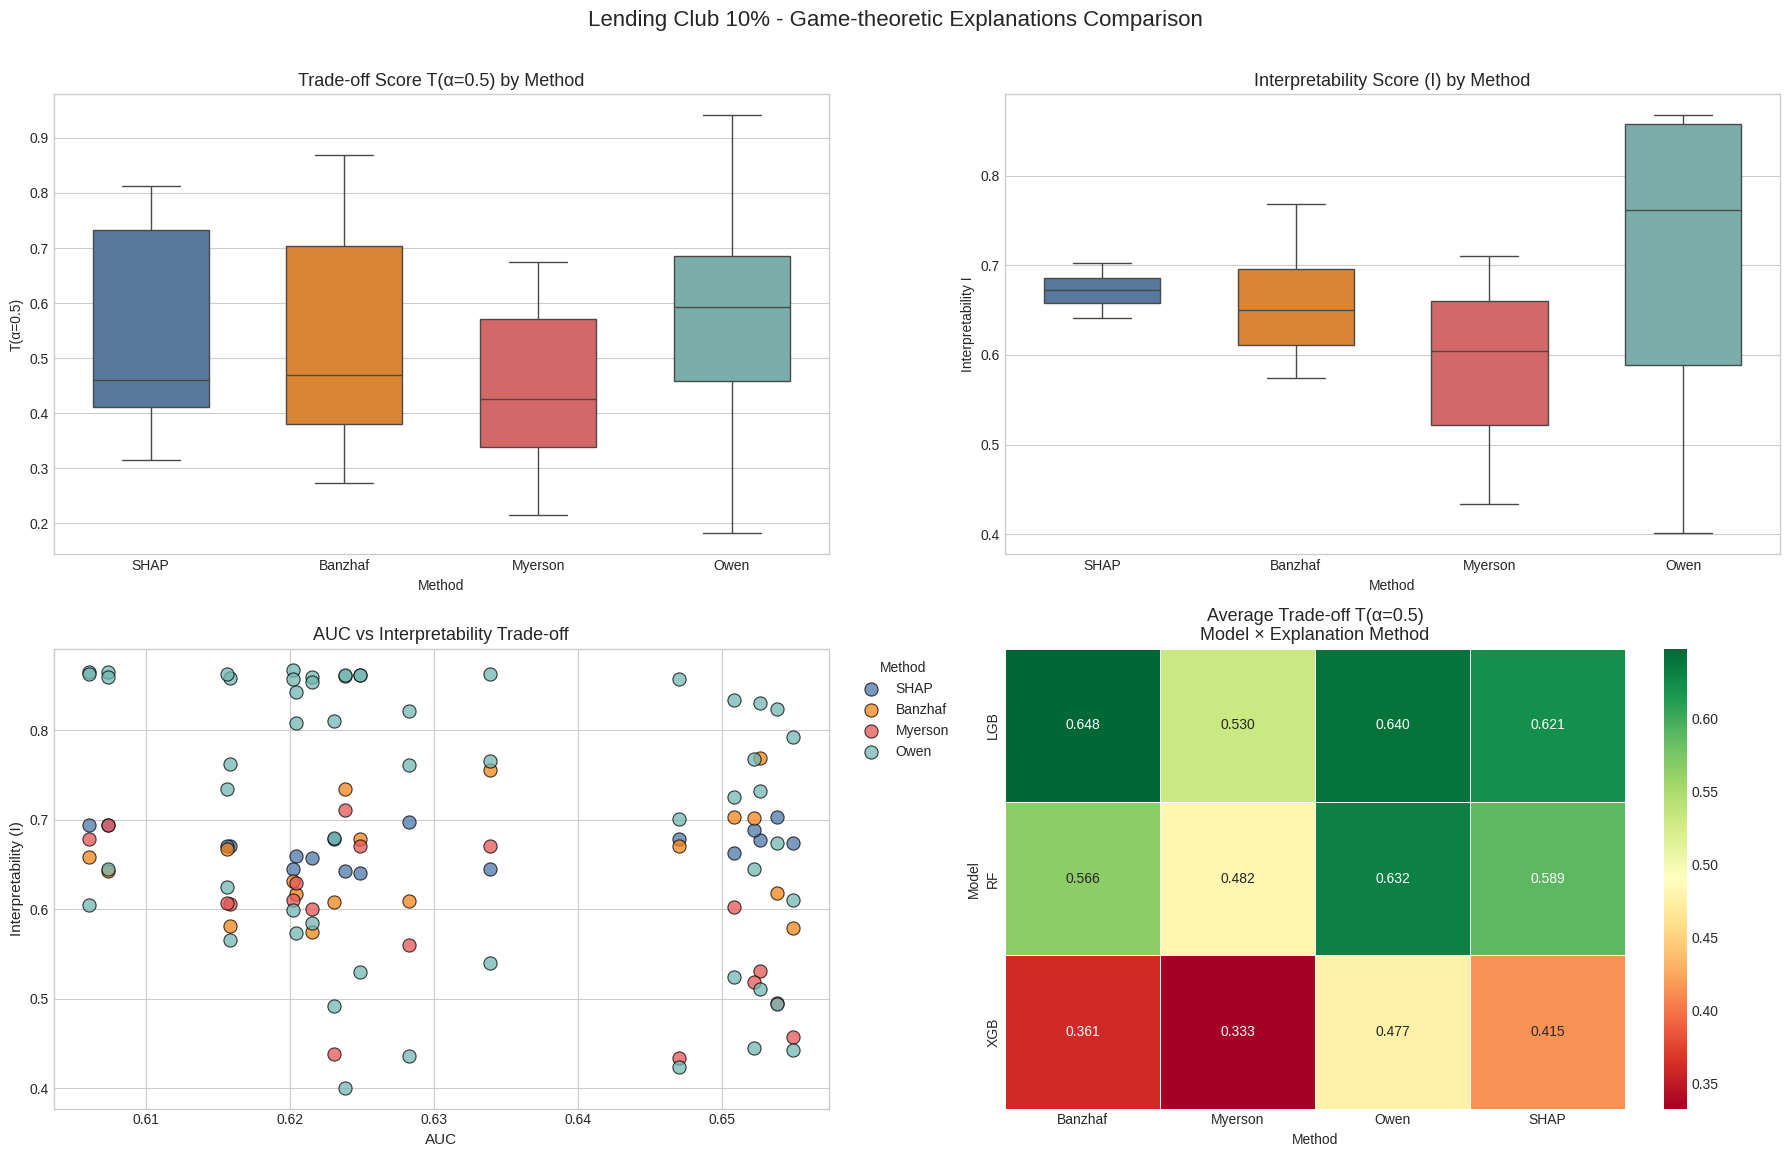

In [2]:
# ============================================================
# STATISTICAL VALIDATION & COMPARATIVE VISUALIZATION
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, kruskal
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*80)
print("STATISTICAL VALIDATION & COMPARATIVE VISUALIZATION")
print("Lending Club 10% Dataset Analysis")
print("="*80)

# ── 0. Safety check ───────────────────────────────────────────────
if 'metrics' not in globals() or metrics.empty:
    try:
        metrics = pd.read_csv('complete_results.csv')
        print("→ Loaded metrics from 'complete_results.csv'")
    except:
        raise FileNotFoundError("Cannot find 'metrics' DataFrame or 'complete_results.csv'")

# Make sure we have the important columns
required_cols = ['Model', 'Sampler', 'Method', 'Grouping', 'AUC', 'I', 'T(α=0.5)', 'Stability', 'Kuncheva', 'Cosine']
missing = [c for c in required_cols if c not in metrics.columns]
if missing:
    print(f"Warning: Missing columns: {missing}")

# Quick helper for nice printing
def print_stat_result(test_name, stat, p, sig_level=0.05):
    sig = "SIGNIFICANT" if p < sig_level else "not significant"
    print(f"{test_name:24}  statistic = {stat:8.3f}    p = {p:.5f}    → {sig}")

# ── 1. Non-parametric group comparison (Kruskal-Wallis) ───────────
print("\n1. Kruskal-Wallis Tests (non-parametric group comparison)\n")

for metric in ['AUC', 'I', 'T(α=0.5)', 'Stability', 'Kuncheva', 'Cosine']:
    groups = [metrics[metrics['Method'] == m][metric].dropna().values
              for m in metrics['Method'].unique()]
    groups = [g for g in groups if len(g) >= 2]  # need at least 2 observations

    if len(groups) >= 2:
        stat, p = kruskal(*groups)
        print_stat_result(f"Kruskal-Wallis {metric}", stat, p)
    else:
        print(f"Kruskal-Wallis {metric:12} → Not enough valid groups for comparison")

# ── 2. Pairwise comparisons (Mann-Whitney U) ──────────────────────
print("\n2. Pairwise Mann-Whitney U tests (T(α=0.5))\n")

methods = sorted(metrics['Method'].unique())
pairs_done = set()

for i, m1 in enumerate(methods):
    for m2 in methods[i+1:]:
        if (m1, m2) in pairs_done or (m2, m1) in pairs_done:
            continue

        d1 = metrics[metrics['Method'] == m1]['T(α=0.5)'].dropna()
        d2 = metrics[metrics['Method'] == m2]['T(α=0.5)'].dropna()

        if len(d1) >= 5 and len(d2) >= 5:  # reasonable minimum size
            stat, p = mannwhitneyu(d1, d2, alternative='two-sided')
            diff = d1.mean() - d2.mean()
            winner = m1 if diff > 0 else m2
            print(f"{m1:10} vs {m2:10} | U = {stat:6.0f}  p = {p:.5f}  → mean diff: {diff:+.4f}  better: {winner}")
        else:
            print(f"{m1:10} vs {m2:10} → insufficient data")

        pairs_done.add((m1, m2))

# ── 3. Visualizations ─────────────────────────────────────────────
print("\n3. Generating comparative visualizations...")

plt.style.use('seaborn-v0_8-whitegrid')
method_palette = {
    'SHAP': '#4C78A8',
    'Banzhaf': '#F58518',
    'Myerson': '#E45756',
    'Owen': '#72B7B2'
}

fig = plt.figure(figsize=(18, 12))
fig.suptitle("Lending Club 10% - Game-theoretic Explanations Comparison", fontsize=16, y=0.96)

# 3.1 Boxplots - main metrics
ax1 = fig.add_subplot(2, 2, 1)
sns.boxplot(data=metrics, x='Method', y='T(α=0.5)', palette=method_palette, ax=ax1, width=0.6)
ax1.set_title("Trade-off Score T(α=0.5) by Method", fontsize=13)
ax1.set_ylabel("T(α=0.5)")

ax2 = fig.add_subplot(2, 2, 2)
sns.boxplot(data=metrics, x='Method', y='I', palette=method_palette, ax=ax2, width=0.6)
ax2.set_title("Interpretability Score (I) by Method", fontsize=13)
ax2.set_ylabel("Interpretability I")

# 3.2 Scatter - AUC vs Interpretability
ax3 = fig.add_subplot(2, 2, 3)
for m in metrics['Method'].unique():
    subset = metrics[metrics['Method'] == m]
    color = method_palette.get(m, '#999999')
    ax3.scatter(subset['AUC'], subset['I'], s=90, alpha=0.75, label=m, color=color, edgecolor='black', linewidth=0.8)
ax3.set_xlabel("AUC", fontsize=11)
ax3.set_ylabel("Interpretability (I)", fontsize=11)
ax3.set_title("AUC vs Interpretability Trade-off", fontsize=13)
ax3.legend(title="Method", bbox_to_anchor=(1.02, 1), loc='upper left')

# 3.3 Heatmap - average trade-off by model × method
ax4 = fig.add_subplot(2, 2, 4)
heatmap_data = metrics.pivot_table(
    index='Model',
    columns='Method',
    values='T(α=0.5)',
    aggfunc='mean'
).round(4)
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax4, linewidths=0.5)
ax4.set_title("Average Trade-off T(α=0.5)\nModel × Explanation Method", fontsize=13)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('lc10pc_game_theory_comparison.png', dpi=300, bbox_inches='tight')
print("→ Main comparative figure saved as: lc10pc_game_theory_comparison.png")

# ── 4. Final Compact Summary ──────────────────────────────────────
print("\n" + "="*80)
print("FINAL COMPACT SUMMARY")
print("="*80)

summary = metrics.groupby('Method').agg({
    'AUC': ['mean', 'std'],
    'I': ['mean', 'std'],
    'T(α=0.5)': ['mean', 'std', 'max'],
    'Stability': 'mean',
    'Kuncheva': 'mean'
}).round(4)

print("\nMethod Performance Summary:")
print(summary)

best = metrics.loc[metrics['T(α=0.5)'].idxmax()]
print(f"\nBest overall configuration:")
print(f"  {best['Model']} + {best['Sampler']} + {best['Method']} ({best['Grouping']})")
print(f"  T(α=0.5) = {best['T(α=0.5)']:.4f}   |   AUC = {best['AUC']:.4f}   |   I = {best['I']:.4f}")

print("\n" + "="*80)
print("Statistical analysis & visualization complete!")
print("="*80)


OWEN GROUPS – DEDICATED VISUALIZATIONS + GROUP QUALITY (Q)
→ Found 54 Owen configurations across 3 groupings

Group Quality (Q) calculation completed.
Q components: Stability + Kuncheva + Cosine + Trade-off + Inverse CV penalty
Q range: 2.2 – 92.8



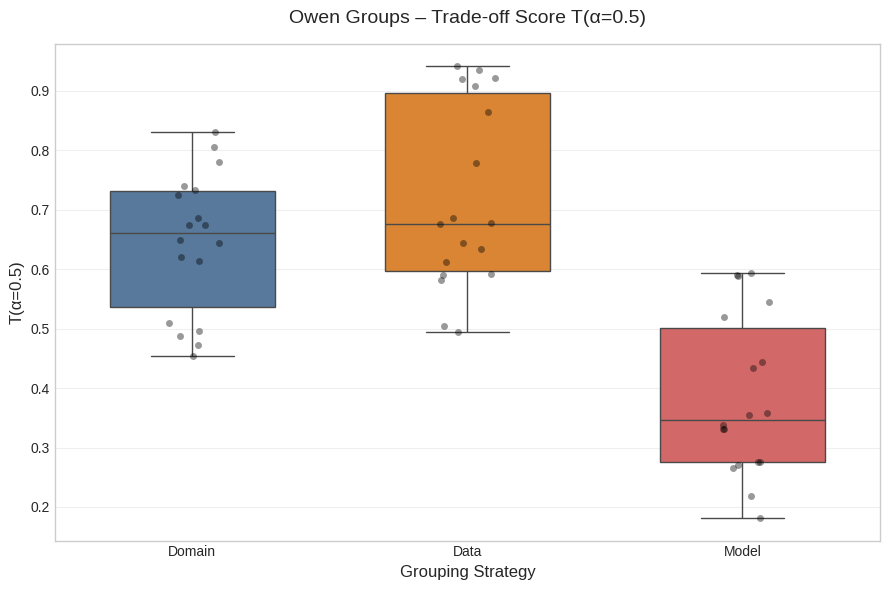

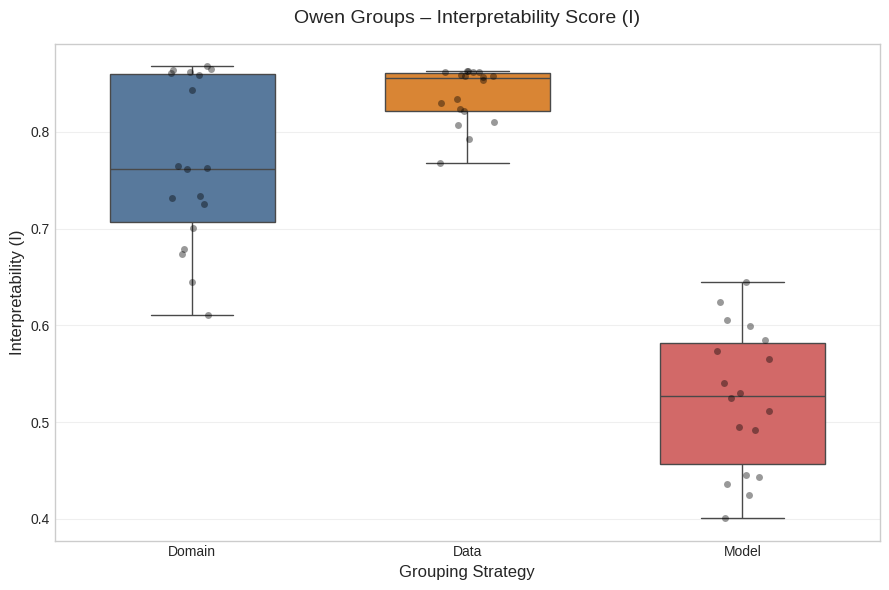

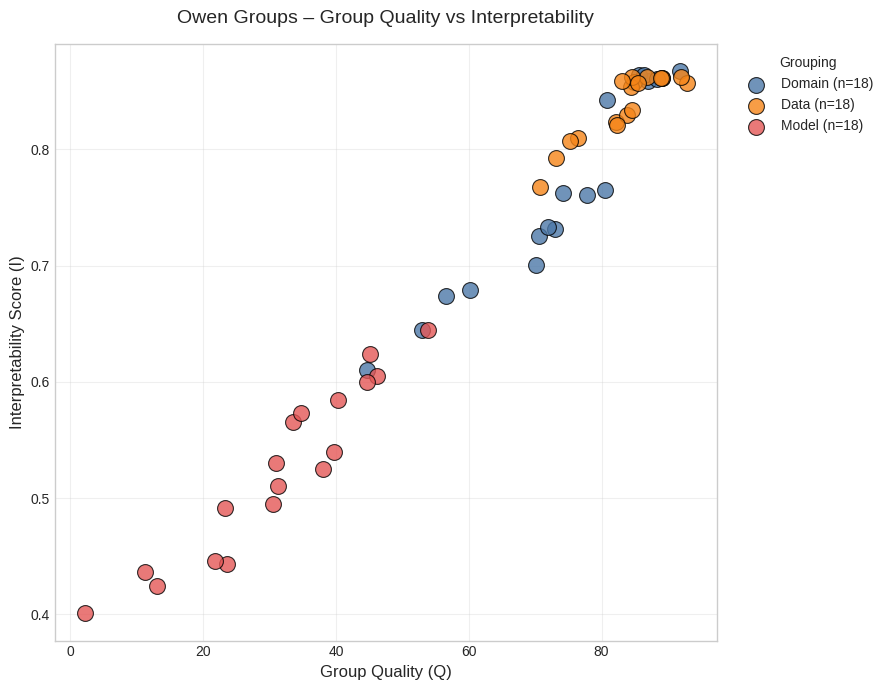

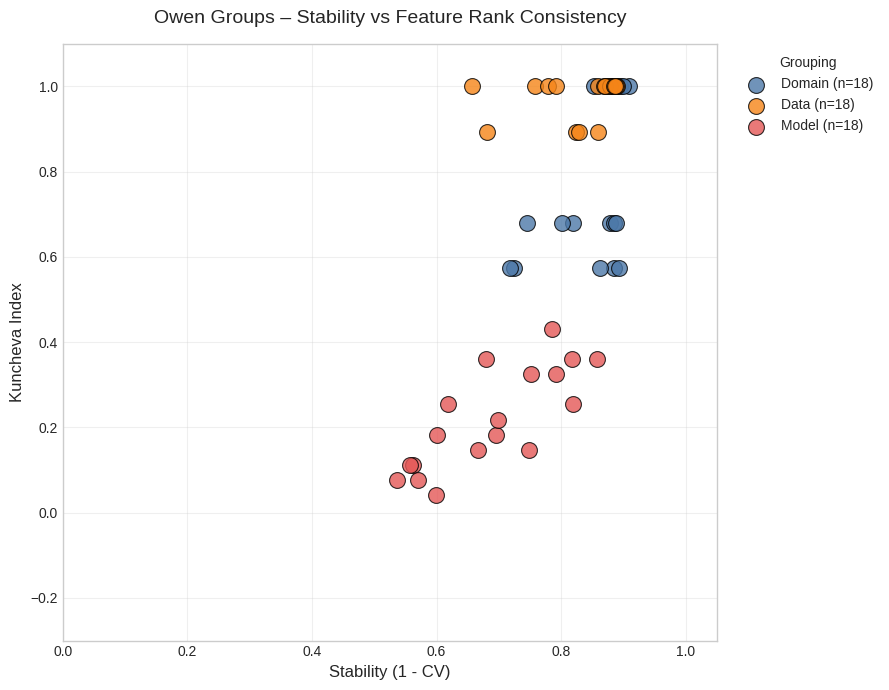

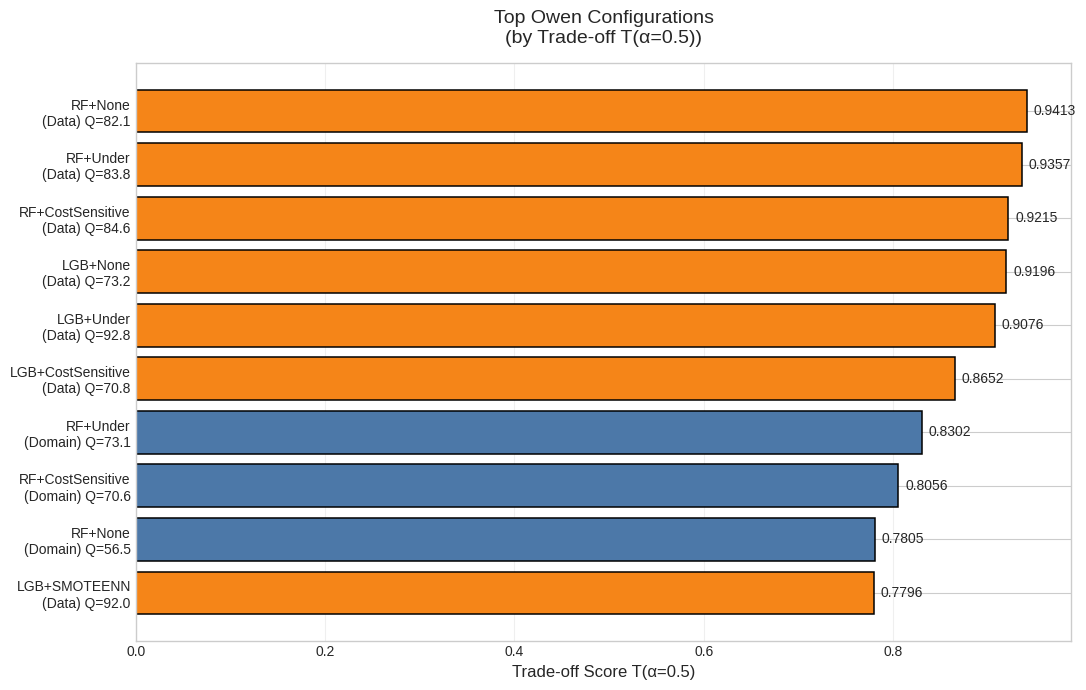


Owen Group Quality Summary:
               Q                         T(α=0.5)      I Stability Kuncheva
            mean     std     min     max     mean   mean      mean     mean
Grouping                                                                   
Data      83.377   6.084  70.783  92.818    0.720  0.838     0.831    0.976
Domain    74.534  13.584  44.721  91.864    0.644  0.767     0.850    0.775
Model     31.342  13.544   2.176  53.866    0.384  0.524     0.687    0.220

Owen-specific visualizations & Group Quality calculation complete!
Generated files:
• owen_tradeoff.png
• owen_interpretability.png
• owen_q_vs_i.png
• owen_stability_vs_kuncheva.png
• top_owen_configurations.png


In [3]:
# ============================================================
# OWEN GROUPS – DEDICATED VISUALIZATIONS + GROUP QUALITY (Q) CALCULATION
# For Lending Club 10% dataset
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*80)
print("OWEN GROUPS – DEDICATED VISUALIZATIONS + GROUP QUALITY (Q)")
print("="*80)

# ── 0. Load or check metrics ───────────────────────────────────────
if 'metrics' not in globals() or metrics.empty:
    try:
        metrics = pd.read_csv('complete_results.csv')
        print("→ Loaded metrics from 'complete_results.csv'")
    except:
        raise FileNotFoundError("Cannot find 'metrics' or 'complete_results.csv'")

# Filter only Owen results
owen = metrics[metrics['Method'] == 'Owen'].copy()

if owen.empty:
    raise ValueError("No Owen method results found in the metrics DataFrame!")

# Make sure Grouping column exists
if 'Grouping' not in owen.columns:
    raise ValueError("No 'Grouping' column found for Owen methods.")

print(f"→ Found {len(owen)} Owen configurations across {owen['Grouping'].nunique()} groupings")

# ── 1. Calculate Group Quality (Q) ─────────────────────────────────
"""
Group Quality (Q) – heuristic composite score:
Higher = better group structure for explanation purposes

Components (each normalized 0–1):
- Stability           → higher better
- Kuncheva            → higher better (feature rank consistency)
- Cosine similarity   → higher better (directional consistency)
- Inverse CV penalty  → lower CV = higher quality
- Trade-off strength  → higher T(α=0.5) contributes positively
"""

def calculate_group_quality(df):
    # Normalize each component (min-max scaling per column)
    df_norm = df.copy()

    for col in ['Stability', 'Kuncheva', 'Cosine', 'T(α=0.5)']:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            df_norm[f'{col}_norm'] = (df[col] - min_val) / (max_val - min_val)
        else:
            df_norm[f'{col}_norm'] = 0.5  # neutral if constant

    # Inverse CV contribution (lower CV = better)
    cv_inv = 1 / (df['CV'] + 1e-6)  # avoid division by zero
    cv_inv_norm = (cv_inv - cv_inv.min()) / (cv_inv.max() - cv_inv.min() + 1e-8)
    df_norm['CV_inv_norm'] = cv_inv_norm

    # Final Q = weighted average (you can tune weights)
    weights = {
        'Stability_norm': 0.25,
        'Kuncheva_norm': 0.25,
        'Cosine_norm': 0.20,
        'T(α=0.5)_norm': 0.20,
        'CV_inv_norm': 0.10
    }

    df_norm['Q'] = sum(df_norm[k] * w for k, w in weights.items())

    # Scale to nice 0–100 range for readability
    df_norm['Q'] = df_norm['Q'] * 100

    return df_norm

# Apply quality calculation
owen = calculate_group_quality(owen)

print("\nGroup Quality (Q) calculation completed.")
print("Q components: Stability + Kuncheva + Cosine + Trade-off + Inverse CV penalty")
print(f"Q range: {owen['Q'].min():.1f} – {owen['Q'].max():.1f}\n")

# ── 2. Color palette for groups ────────────────────────────────────
group_colors = {
    'Domain': '#4C78A8',   # Blue
    'Data':   '#F58518',   # Orange
    'Model':  '#E45756'    # Red
}

# ── 3. Visualizations ──────────────────────────────────────────────
plt.style.use('seaborn-v0_8-whitegrid')

# 3.1 Trade-off by Owen Grouping
plt.figure(figsize=(9, 6))
sns.boxplot(data=owen, x='Grouping', y='T(α=0.5)', palette=group_colors, width=0.6)
sns.stripplot(data=owen, x='Grouping', y='T(α=0.5)', color='black', alpha=0.4, size=5)
plt.title("Owen Groups – Trade-off Score T(α=0.5)", fontsize=14, pad=15)
plt.ylabel("T(α=0.5)", fontsize=12)
plt.xlabel("Grouping Strategy", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('owen_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.2 Interpretability by Owen Grouping
plt.figure(figsize=(9, 6))
sns.boxplot(data=owen, x='Grouping', y='I', palette=group_colors, width=0.6)
sns.stripplot(data=owen, x='Grouping', y='I', color='black', alpha=0.4, size=5)
plt.title("Owen Groups – Interpretability Score (I)", fontsize=14, pad=15)
plt.ylabel("Interpretability (I)", fontsize=12)
plt.xlabel("Grouping Strategy", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('owen_interpretability.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.3 Q vs Interpretability
plt.figure(figsize=(9, 7))
for g in group_colors:
    subset = owen[owen['Grouping'] == g]
    plt.scatter(subset['Q'], subset['I'], s=130, alpha=0.8,
                label=f"{g} (n={len(subset)})",
                color=group_colors[g], edgecolor='black', linewidth=0.8)
plt.xlabel("Group Quality (Q)", fontsize=12)
plt.ylabel("Interpretability Score (I)", fontsize=12)
plt.title("Owen Groups – Group Quality vs Interpretability", fontsize=14, pad=15)
plt.legend(title="Grouping", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('owen_q_vs_i.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.4 Stability vs Kuncheva
plt.figure(figsize=(9, 7))
for g in group_colors:
    subset = owen[owen['Grouping'] == g]
    plt.scatter(subset['Stability'], subset['Kuncheva'], s=130, alpha=0.8,
                label=f"{g} (n={len(subset)})",
                color=group_colors[g], edgecolor='black', linewidth=0.8)
plt.xlabel("Stability (1 - CV)", fontsize=12)
plt.ylabel("Kuncheva Index", fontsize=12)
plt.title("Owen Groups – Stability vs Feature Rank Consistency", fontsize=14, pad=15)
plt.legend(title="Grouping", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.xlim(0, 1.05)
plt.ylim(-0.3, 1.1)
plt.tight_layout()
plt.savefig('owen_stability_vs_kuncheva.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.5 Top 5 Owen Configurations
top5_owen = owen.nlargest(10, 'T(α=0.5)')  # show top 10 for more context

plt.figure(figsize=(11, 7))
labels = [f"{row.Model}+{row.Sampler}\n({row.Grouping}) Q={row['Q']:.1f}"
          for _, row in top5_owen.iterrows()]

bars = plt.barh(labels, top5_owen['T(α=0.5)'],
                color=[group_colors[g] for g in top5_owen['Grouping']],
                edgecolor='black', linewidth=1.1)

plt.bar_label(bars, fmt='%.4f', padding=5, fontsize=10)
plt.xlabel("Trade-off Score T(α=0.5)", fontsize=12)
plt.title("Top Owen Configurations\n(by Trade-off T(α=0.5))", fontsize=14, pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top_owen_configurations.png', dpi=300, bbox_inches='tight')
plt.show()

# ── Summary Table ──────────────────────────────────────────────────
print("\nOwen Group Quality Summary:")
summary_q = owen.groupby('Grouping').agg({
    'Q': ['mean', 'std', 'min', 'max'],
    'T(α=0.5)': 'mean',
    'I': 'mean',
    'Stability': 'mean',
    'Kuncheva': 'mean'
}).round(3)

print(summary_q)

print("\n" + "="*80)
print("Owen-specific visualizations & Group Quality calculation complete!")
print("Generated files:")
print("• owen_tradeoff.png")
print("• owen_interpretability.png")
print("• owen_q_vs_i.png")
print("• owen_stability_vs_kuncheva.png")
print("• top_owen_configurations.png")
print("="*80)